There are three general cases where we want to construct a scheduler to make observations:

1) We have a large area we would like to observe (in one or more filters) in an intelligent way.  In this case, we typically define a survey footprint with HEALpix maps and use one or more `BlobSurvey` objects to execute the observations. This is how we execute the main LSST survey, including things like the Wide Fast Deep area and the North Ecliptic Spur. 
2) We have a list of pointings we would like executed at a specific time. This case can be done with `ScriptedSurvey` objects. 
3) We would like to select the best choice from a list of potential pointings. This doesn't come up for the main LSST survey, but can be useful for AuxTel and commissioning studies.  

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import PointingsSurvey
from rubin_scheduler.scheduler.utils import empty_observation
from rubin_scheduler.scheduler.schedulers import CoreScheduler

from astropy import units
from astropy.coordinates import Angle

import pickle

In [2]:
# Read in a list of pointings we might want to observe
tiles = pd.read_csv('auxtel_tiles.txt', delimiter=' ')
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
794,AUXTEL_PHOTO_IMAGING,Photo1800-1_028,18:00:46.04,-24:57:20.25
795,AUXTEL_PHOTO_IMAGING,Photo1800-1_029,18:00:49.96,-24:57:20.25
796,AUXTEL_PHOTO_IMAGING,Photo1800-1_030,18:00:53.88,-24:57:20.25
797,AUXTEL_PHOTO_IMAGING,Photo1800-1_031,18:00:57.79,-24:57:20.25


In [3]:
# Convert pointings to an observation array
obs = empty_observation(n=len(tiles))
obs['note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['filter'] = 'r'
obs['exptime'] = 60.

In [4]:
# load the potential observations into a PointingsSurvey
# by default, the PointingsSurvey will stick on a detailer that 
# sets each observation to the parallactic angle. For now we'll clobber 
# that so all the observations get taken with rotTelPos=0
ps = PointingsSurvey(obs, detailers=[])
sched = CoreScheduler([ps])


In [5]:
# Try observing with the survey for 3 days
mo = ModelObservatory()
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: divide by zero encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:280: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.00%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1886 observations
ran in 0 min = 0.0 hours


Text(0.5, 1.0, 'Completed observations')

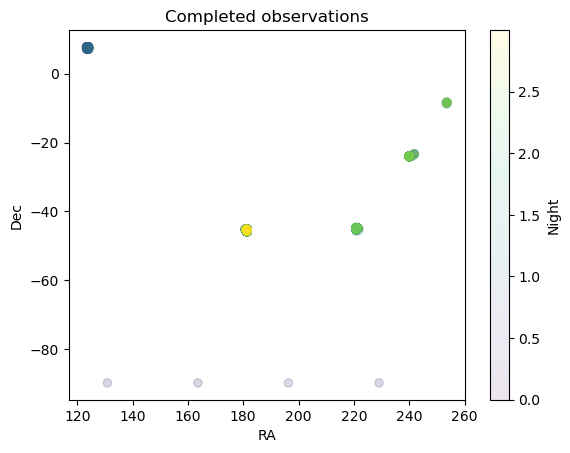

In [6]:
# plot the observations that were taken
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(completed_obs['RA']), np.degrees(completed_obs['dec']),
            c=completed_obs['mjd']-completed_obs['mjd'].min(), alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Night')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Completed observations')

In [7]:
# What does the scheduler look like
sched

CoreScheduler(
            surveys=[[<PointingsSurvey at 0x2866aff50>]],
            camera="LSST",
            nside=32,
            rotator_limits=array([1.48352986, 4.79965544]),
            survey_index=[0, 0],
            log=<Logger CoreScheduler (WARNING)>
        )

In [8]:
# output a pretty table showing the current status of the survey. 
# This is a stubb in place so things should be easy to pass to schedview
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,776,1.0,0.000000,776
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,776
2,m5diff,None,True,-0.138521,313,1.0,0.861479,290
3,slew_time,None,True,-3.843154,313,-1.0,-3.068583,290
4,wind_limit,None,True,0.000000,799,0.0,-3.068583,290
5,ha_limit,None,True,0.000000,132,0.0,-3.068583,109
6,alt_limit,None,True,0.000000,313,0.0,-3.068583,109
7,moon_limit,None,True,0.000000,735,0.0,-3.068583,45


Text(0, 0.5, 'Dec')

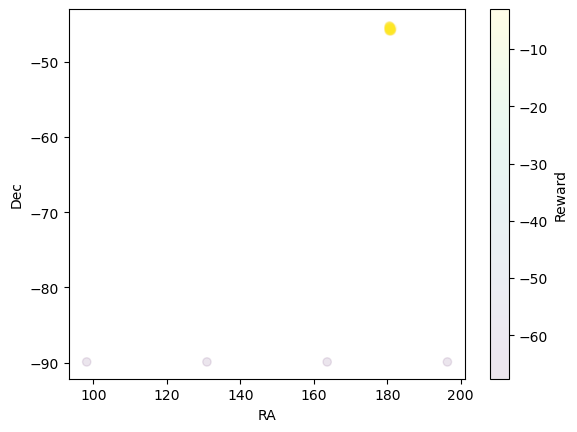

In [9]:
# can look at the reward for each potential observations on the sky
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(sched.survey_lists[0][0].observations['RA']),
            np.degrees(sched.survey_lists[0][0].observations['dec']),
            c=sched.survey_lists[0][0].reward, alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Reward')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [10]:
# How big is it to dump this scheduler
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()
from subprocess import Popen
Popen('ls -lh *.pkl', shell=True)

<Popen: returncode: None args: 'ls -lh *.pkl'>

Pros and cons

Cons:

* Not as modular as using basis function objects
* Setting an altitude limit of observations taken by a `PointingSurvey` object is done differently than in a `BlobSurvey`. (but we have the same issue with `ScriptedSurveys` where the logic on when to execute doesn't use only basis functions.)

Pros

* Scalable. 1 to 1,000,000 potential pointings, no problem. No looping over many survey objects.
* Small memory/storage footprint. 3M uncompressed, <1M compressed. Current Auxtel uncompressed is 157M
* Easy to output debugging data frame analagous to the other surveys
* Easier to configure since all the logic is already in the class. One-liner to make the survey class

## Example removing the 5-sigma depth logic in making decisions on what to observe

In [11]:
# Say we want to lift the m5 and moon limits. Just remove them from the weights dict
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

-rw-r--r--  1 yoachim  staff   3.9M Jan 10 17:01 save_test.pkl


In [12]:
mo = ModelObservatory()
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: divide by zero encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:280: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.00%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1884 observations
ran in 0 min = 0.0 hours


In [13]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,776,1.0,0.000000,776
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,776
2,slew_time,None,True,-3.978996,313,-1.0,-3.017308,290
3,wind_limit,None,True,0.000000,799,0.0,-3.017308,290
4,ha_limit,None,True,0.000000,132,0.0,-3.017308,109
5,alt_limit,None,True,0.000000,313,0.0,-3.017308,109


## Example using Sequence Boost

In [14]:
# Let's try out the sequence boost
obs_boost = obs.copy()

# Say we want to make sure all 4 of seq1 execute, and all 5 in seq2 execute
sequence_boost = {'seq1': 4, 'seq2': 5}
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0, 'sequence_boost': 5.}

# Change the note so scheduler can recognize things as belonging to the same sequence
for i in np.arange(4):
    match = np.where(obs['note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_00%i' % (i+1))[0]
    obs_boost['note'][match] = 'seq1_%i' % i

# and say we always want to take 5 of this one in a sequence. Need to give each part of 
# the sequence it's own observation.
match = np.where(obs['note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_020')[0]

five_obs = empty_observation(5)
for key in five_obs.dtype.names:
    five_obs[key] = obs[match][key].copy()
for i in range(5):
    five_obs[i]["note"] = "seq2_%i" % i

obs_boost = np.hstack([obs_boost, five_obs])

# Here we've used the sequence boost to try and make things be taken in sequences.
# One could also imagine making a detailer that makes sure every time a pointing is selected,
# it gets converted into the desired sequence. 


In [15]:
ps = PointingsSurvey(obs_boost, detailers=[], weights=weights, track_notes_ngoal=sequence_boost)
sched = CoreScheduler([ps])

mo = ModelObservatory()
mo, sched, completed_obs = sim_runner(mo, sched, survey_length=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:280: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.00%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1886 observations
ran in 0 min = 0.0 hours


In [16]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,781,1.0,0.000000,781
1,balance_revisit,None,True,1.000000,804,1.0,1.000000,781
2,slew_time,None,True,-3.978996,313,-1.0,-3.017308,290
3,wind_limit,None,True,0.000000,804,0.0,-3.017308,290
4,ha_limit,None,True,0.000000,132,0.0,-3.017308,109
5,alt_limit,None,True,0.000000,313,0.0,-3.017308,109
6,sequence_boost,None,True,0.000000,804,5.0,-3.017308,109


In [17]:
# Let's see how the sequences look.
seq_indx = ['seq' in s for s in completed_obs["note"]]
df = pd.DataFrame(completed_obs[seq_indx])


In [18]:
# does something different happen with no sequence boost?
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0.}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

mo = ModelObservatory()
mo, sched, completed_obs2 = sim_runner(mo, sched, survey_length=3)

conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: divide by zero encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)
/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:246: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 65.27%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:280: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.00%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1884 observations
ran in 0 min = 0.0 hours


,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,776,1.0,0.000000,776
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,776
2,slew_time,None,True,-3.978996,313,-1.0,-3.017308,290
3,wind_limit,None,True,0.000000,799,0.0,-3.017308,290
4,ha_limit,None,True,0.000000,132,0.0,-3.017308,109
5,alt_limit,None,True,0.000000,313,0.0,-3.017308,109


In [19]:
# Took the same total number of images, but not the same positions.
check = True
if completed_obs["RA"].size == completed_obs2["RA"].size:
    check = ~np.all(completed_obs["RA"] == completed_obs2["RA"])
print("Did we point differently with the sequence boost on?", check)

Did we point differently with the sequence boost on? True
